In [4]:
import os
import sys
from sys import platform
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

# Add the parent directory to the sys.path (without this we cannot import constants or scripts)
sys.path.insert(0, str(Path.cwd().parent))
from src.plotting import plot_comparison_GER_HIC_GLO
from constants.countries import highincome_countries
from src.utils import get_iso3_gbd, generate_high_income_global_avg_index

%load_ext autoreload

In [5]:
import matplotlib.pyplot as plt 

from tueplots import bundles

In [6]:
# if platform == 'darwin': # macos
#     print('mac os')
#     os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [7]:
DATA_PATH = '../data/final'
OUTPUT_PATH = '../doc/IHD_germany_2024/fig'
cvd_data_path = f'{DATA_PATH}/gbd_cardiovascular_allAges_final.csv'
YEAR_COLUMN_NAME = 'year'
VALUE_COLUMN_NAME = 'val'

## Load Data

In [8]:
df = pd.read_csv(cvd_data_path)
df = df[df.measure_name=='Deaths']
df['country_code'] = df['location_name'].map(get_iso3_gbd)

In [9]:
df = df[['location_name', 'country_code', 'year', 'val']]
df.columns = ['Country Name', 'Country Code', 'Year', 'IHD']

In [10]:
df['Country Code'].nunique()

206

In [11]:
year_cols = [str(i) for i in range(1960, 2023)]

In [12]:
health_df = pd.read_csv('../data/raw/health_expenditure.csv')
health_df = health_df.melt(id_vars=['Country Name', 'Country Code'], value_vars=year_cols, var_name='Year', value_name='HealthInd')
health_df['Year'] = health_df['Year'].astype(int)
health_df = health_df.drop(['Country Name'], axis=1)
health_df = health_df.dropna()

In [13]:
health_df.dropna()['Country Code'].nunique()

238

In [14]:
# health_df = pd.read_csv(DATA_PATH+'/oecd_combined_final.csv')
# health_df = health_df.rename({'Value': 'HealthInd'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [15]:
fat_df = pd.read_csv(DATA_PATH+'/daily_per_capita_fat_supply_final.csv')
fat_df = fat_df.rename({'Value': 'Fat'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [16]:
alc_df = pd.read_csv(DATA_PATH+'/wdi_AlcoholConsumption.csv')
alc_df = alc_df.rename({'Value': 'Alcohol'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [17]:
age_df = pd.read_csv('../data/raw/median-age.csv')
age_df = age_df[['Code', 'Year', 'Median age - Sex: all - Age: all - Variant: estimates']]
age_df.columns = ['Country Code', 'Year', 'Age']

In [18]:
final_df = df.merge(health_df, on=['Country Code', 'Year'])
final_df = final_df.merge(alc_df, on=['Country Code', 'Year'])
# final_df = final_df.merge(fat_df, on=['Country Code', 'Year'])
final_df = final_df.merge(age_df, on=['Country Code', 'Year'])

In [19]:
final_df

,Country Name,Country Code,Year,IHD,HealthInd,Alcohol,Age
0,Samoa,WSM,2000,0.368311,4.396606,4.04168,18.5
1,Samoa,WSM,2000,237.006361,4.396606,4.04168,18.5
2,Austria,AUT,2000,0.473877,9.203713,12.89070,37.1
3,Austria,AUT,2000,452.709757,9.203713,12.89070,37.1
4,Vanuatu,VUT,2000,0.317660,3.306833,1.26851,17.0
...,...,...,...,...,...,...,...
1811,Cyprus,CYP,2019,236.959544,6.949430,8.05289,36.6
1812,Belarus,BLR,2019,0.619024,5.861338,10.90107,39.7
1813,Belarus,BLR,2019,792.975384,5.861338,10.90107,39.7
1814,Sweden,SWE,2019,0.384713,10.832243,9.29617,39.6


In [20]:
mean_df = final_df.groupby(['Country Name', 'Country Code'])[['IHD', 'HealthInd', 'Alcohol', 'Age']].last().reset_index()

In [21]:
%autoreload 2
mean_df = generate_high_income_global_avg_index(mean_df, value_cols=['IHD', 'HealthInd', 'Alcohol', 'Age'], year_col=None)

In [22]:
# mean_df[mean_df['Is High Income']]

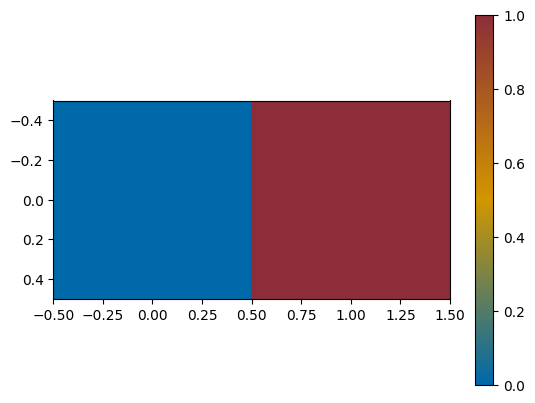

In [23]:
from tueplots.constants.color import rgb

from matplotlib.colors import LinearSegmentedColormap

cmap_colors = [
    (0.0, rgb.tue_blue),
    (0.5, rgb.tue_orange),
    (1.0, rgb.tue_red)
]

# Create a colormap object
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

# Use this colormap
plt.imshow([[0,1]], cmap=custom_cmap)
plt.colorbar()
plt.show()

In [27]:
def bubble_plot_factors_and_rates(input_df, x_col, y_col, size_col, hue_col, country_col,
                                x_label, y_label, size_label, hue_label, min_dist,
                                title, output_path, white_list=['DEU', 'HIC', 'GLB']
                                ):
    df = input_df.copy()
    
    plt.rcParams.update(bundles.icml2022(column="full", ncols=2, nrows=1))
    
    df[size_col + '_rescaled'] = (df[size_col] - df[size_col].min()) * 5
    scatter = plt.scatter(df[x_col], 
                        df[y_col], 
                        s=df[size_col+'_rescaled'],  # This argument specifies the size of the bubbles,
                        alpha=0.5, c=df[hue_col], cmap=custom_cmap)

    # Add labels for the x and y axes
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # white_list = ['Germany', 'United States of Ameria', 'United Kingdom', 'United ']
    coords = np.zeros(shape=(len(df), 2))

    # Optionally add country labels
    
    for i, row in df.iterrows():
        # if row['Country Name'] in highincome_countries:
        curr_coord = np.array([row[x_col], row[y_col]])
        dist = np.linalg.norm(curr_coord.reshape(-1,2) - coords, axis=1)
        # print(coords)
        coords[i] = curr_coord
        if  row[country_col] in white_list:
        # if row[country_col] in white_list:
                size = 5 
                plt.text(row[x_col]-0.25, 
                        row[y_col]-0.4, 
                        s=row[country_col],
                        size=size)

    plt.colorbar(scatter, label=hue_label)

    pct = [20, 50, 80]
    legend_sizes = np.percentile(df[size_col + '_rescaled'], pct)
    # print(legend_sizes)
    legend_labels_int = [str(int(age)) for age in np.percentile(df[size_col], pct)]
    legend_labels = [None, None, None]
    legend_labels[0] = "under " + legend_labels_int[0]
    legend_labels[1] = "from " + legend_labels_int[0] + " to " + legend_labels_int[2]
    legend_labels[2] = "above " + legend_labels_int[2]

    # Create a list of legend entries
    legend_entries = [plt.scatter([], [], s=size, color='grey', label=label)
                    for label, size in zip(legend_labels, legend_sizes)]
    plt.legend(handles=legend_entries, title=size_label, ncol=3, loc='upper right')

    plt.title(title)

    plt.savefig(output_path)
    plt.show()

In [25]:
white_list = ['Afghanistan',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Barbados',
 'Belarus',
 'Bulgaria',
 'China',
 'Colombia',
 'Costa Rica',
 'Cuba',
 'Czechia',
 'Ecuador',
 'France',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kenya',
 'Latvia',
 'Luxembourg',
 'Mongolia',
 'Montenegro',
 'Myanmar',
 'Paraguay',
 'Peru',
 'Romania',
 'Samoa',
 'Slovakia',
 'Slovenia',
 'Sweden',
 'Tunisia',
 'United States of America',
 'Uruguay',
 'High-income',
 'Global']

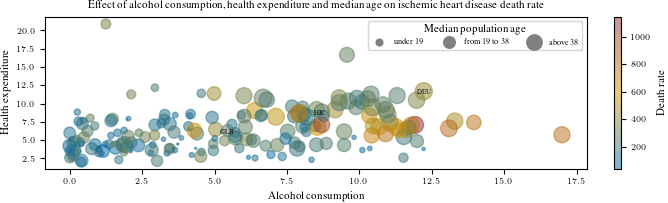

In [28]:
output_fig_path = OUTPUT_PATH + '/fig_bubble_plot_factors.pdf'
bubble_plot_factors_and_rates(mean_df, x_col='Alcohol', y_col='HealthInd', size_col='Age', hue_col='IHD',
                            x_label='Alcohol consumption', y_label='Health expenditure',
                            size_label='Median population age', hue_label='Death rate',
                            country_col='Country Code', min_dist=0.6,
                            title='Effect of alcohol consumption, health expenditure and median age on ischemic heart disease death rate',
                            output_path=output_fig_path)
                            # , white_list=white_list)   